# Tracing Workflows with Arize Phoenix

This notebook demonstrates how to gain real-time observability for your [LlamaIndex Workflows](https://docs.llamaindex.ai/en/stable/module_guides/workflow/) by ingesting traces to [Arize Phoenix](https://arize.com/docs/phoenix/integrations/frameworks/llamaindex/llamaindex-workflows-tracing).

Arize Phoenix offers several versions of their tracing platform (cloud, self-hosted docker, notebook). In this example, we will use the notebook-friendly version, but you can visit [their docs](https://arize.com/docs/phoenix/integrations/frameworks/llamaindex/llamaindex-workflows-tracing) to explore all options!

## Step 1: Install Dependencies, set keys

In [ ]:
%pip install arize-phoenix llama-index-workflows llama-index-instrumentation openinference-instrumentation-llama_index
# Optional if using openai or other llama-index packages
%pip install llama-index-llms-openai

In [1]:
import os

# Your openai key
os.environ["OPENAI_API_KEY"] = "sk-proj-..."

## Step 2: Launch Arize Phoenix

In [ ]:
import phoenix as px

px.launch_app()

## Step 3: Initialize LlamaIndex Instrumentation

Now, we initialize the [OpenInference LlamaIndex instrumentation](https://docs.arize.com/phoenix/tracing/integrations-tracing/llamaindex). This third-party instrumentation automatically captures LlamaIndex operations and exports OpenTelemetry (OTel) spans to Arize Phoenix.

In [ ]:
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor
from phoenix.otel import register

tracer_provider = register()
LlamaIndexInstrumentor().instrument(tracer_provider=tracer_provider)

## Step 4: Create a Simple LlamaIndex Workflows Application

In LlamaIndex Workflows, you build event-driven AI agents by defining steps with the `@step` decorator. Each step processes an event and, if appropriate, emits new events.

In [5]:
from typing import Annotated

from llama_index.core.llms import ChatMessage
from llama_index.llms.openai import OpenAI
from workflows import Workflow, step
from workflows.events import StartEvent, StopEvent
from workflows.resource import Resource


def get_llm():
    return OpenAI(model="gpt-4.1-mini")


class MyWorkflow(Workflow):
    @step
    async def step1(
        self, ev: StartEvent, llm: Annotated[OpenAI, Resource(get_llm)]
    ) -> StopEvent:
        message = ChatMessage(role="user", content=ev.get("input"))
        response = await llm.achat([message])
        return StopEvent(result=response.message.content)


wf = MyWorkflow()

In [6]:
response = await wf.run(input="Hi there!")
print(response)

Hello! How can I assist you today?


## Step 5: View Traces in Arize Phoenix

After running your workflow, open Arize Phoenix (which in this case is running at [http://localhost:6006/](http://localhost:6006/)) to explore the generated traces. You will see logs for each workflow step along with metrics such as latencies, and execution paths. 

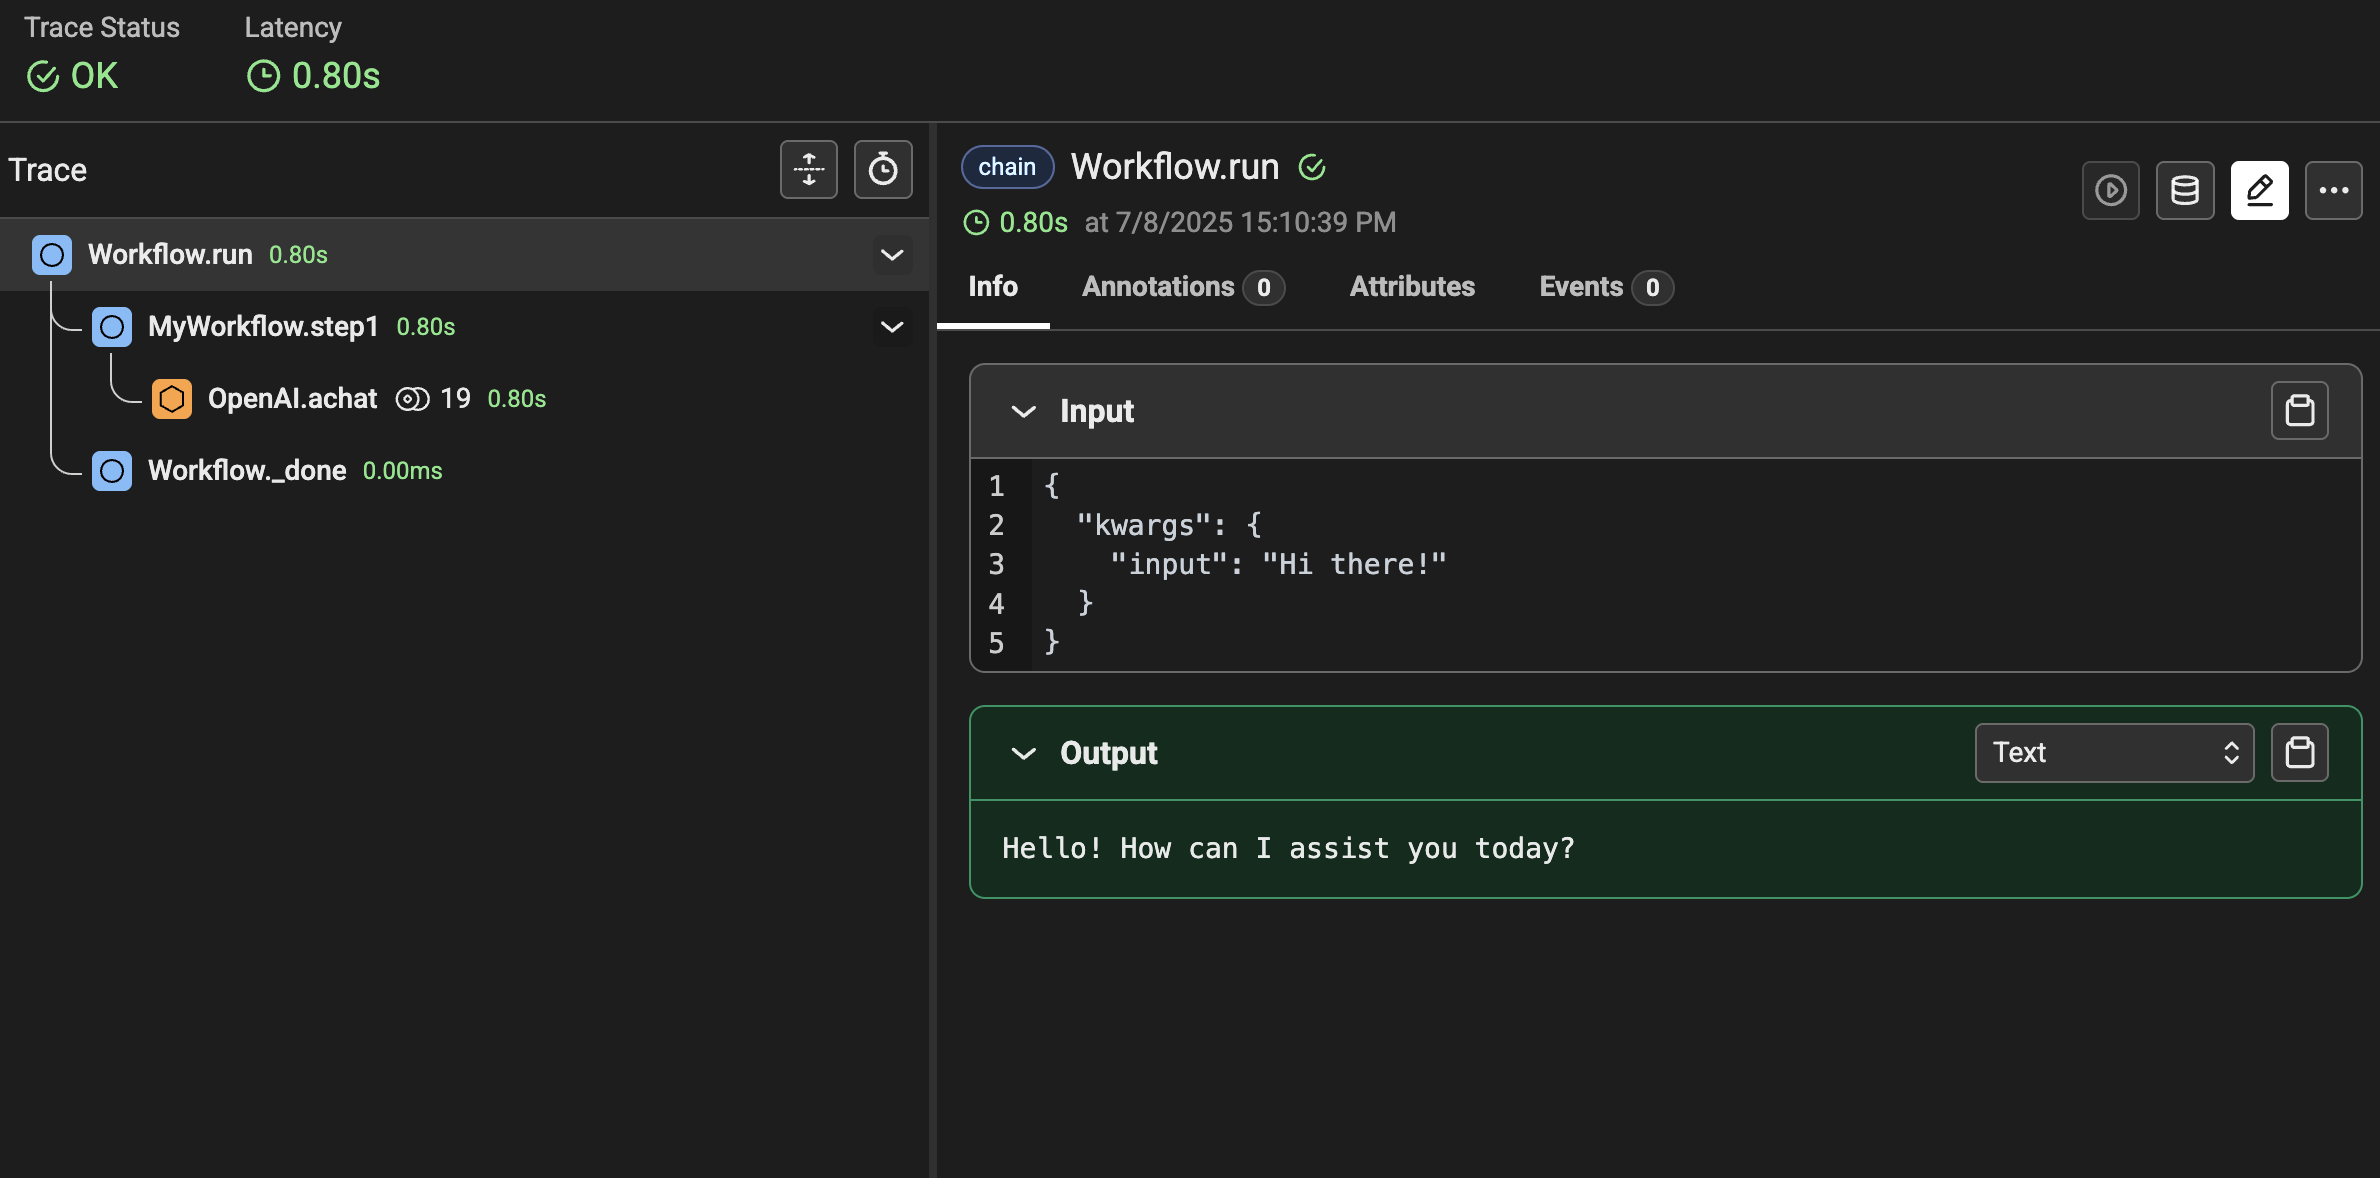

## References

- [LlamaIndex Workflows documentation](https://docs.llamaindex.ai/en/stable/module_guides/workflow/)  
- [Arize + LlamaIndex Docs Hub](https://arize.com/docs/phoenix/integrations/frameworks/llamaindex)

# (Optional) Step 6: Adding Custom Spans and Events

Using the `llama-index-instrumentation` package, you can add custom spans and events to your workflow!

In [7]:
from llama_index_instrumentation import get_dispatcher
from llama_index_instrumentation.base import BaseEvent

dispatcher = get_dispatcher()


class MyEvent(BaseEvent):
    data: str


@dispatcher.span
def my_span(data: str) -> None:
    dispatcher.event(MyEvent(data=data))
    print(data)

Since workflows are automatically instrumented, any custom events and spans will be automatically captured and ingested into Langfuse as a workflow runs!

In [8]:
from typing import Annotated

from llama_index.llms.openai import OpenAI
from workflows import Workflow, step
from workflows.events import StartEvent, StopEvent
from workflows.resource import Resource


def get_llm():
    return OpenAI(model="gpt-4.1-mini")


class MyWorkflow(Workflow):
    @step
    async def step1(
        self, ev: StartEvent, llm: Annotated[OpenAI, Resource(get_llm)]
    ) -> StopEvent:
        message = ChatMessage(role="user", content=ev.get("input"))
        response = await llm.achat([message])

        # This will create a custom span and event in Langfuse
        my_span("This is a custom span")

        return StopEvent(result=response.message.content)


wf = MyWorkflow()
response = await wf.run(input="Hi there!")
print(response)

This is a custom span
Hello! How can I assist you today?


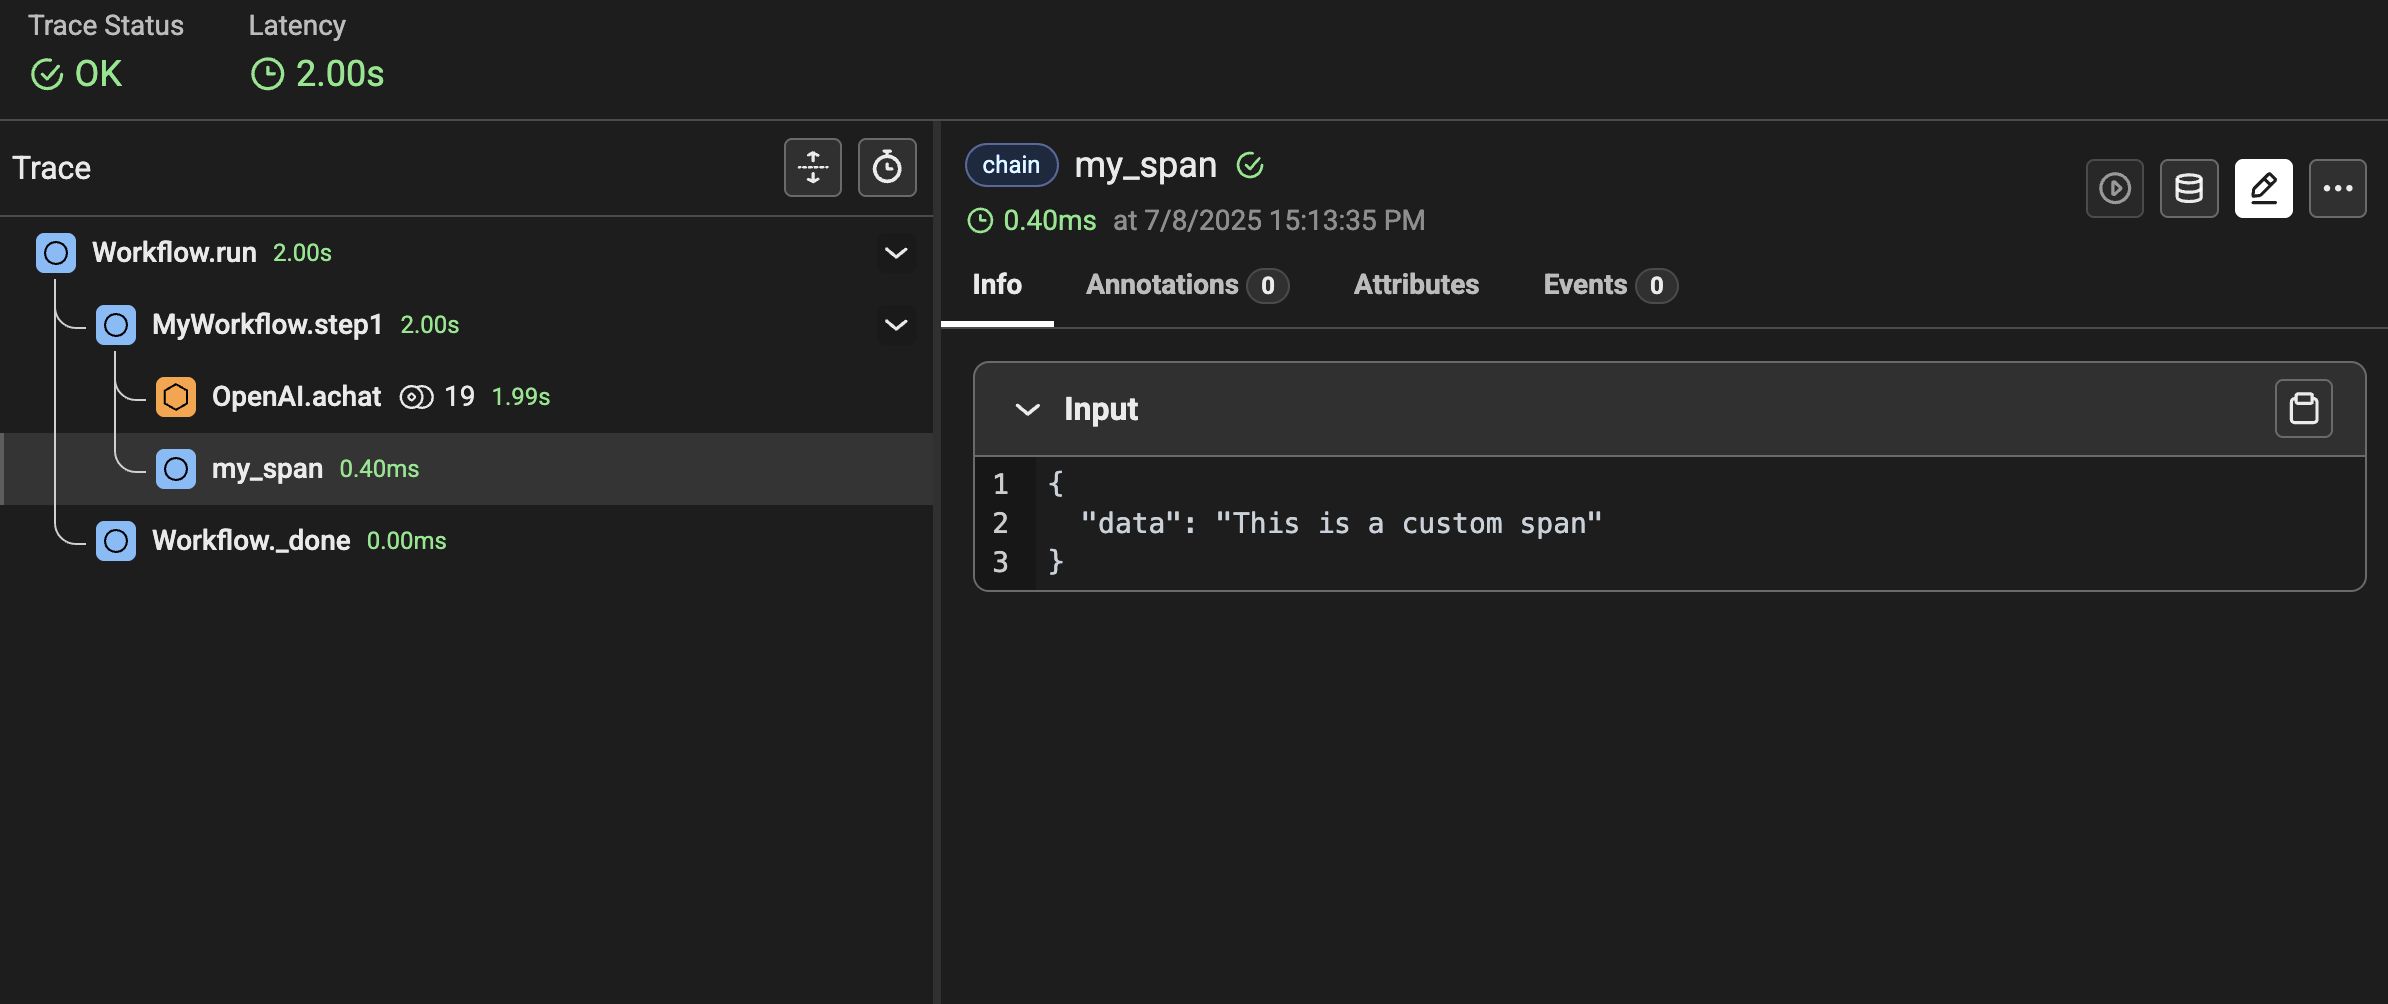